In [1]:
import time

import jax
import jax.numpy as jnp

import equinox as eqx

import matplotlib.pyplot as plt

# JAX by example: learning for control

This tutorial will introduce the basics of [JAX](https://jax.readthedocs.io/en/latest/). The pitch for JAX is simple: combine automatic differentiation and XLA (accelerated linear algebra) to dramatically accelerate numerical methods and machine learning while requiring relatively little overhead beyond standard Python+NumPy.

This tutorial provides a *brief* introduction to JAX, and it's intended more to convince you to learn more rather than teach you everything you need to know about JAX (the [JAX docs](https://jax.readthedocs.io/en/latest/) are quite good and easy to reference). **By the end of this tutorial, you should be able to...**

1. Convert Numpy code to JAX
2. Accelerate your code using just-in-time compilation
3. Use automatic differentiation to do simple gradient-based optimization of a control policy

## Stage 1: How to write and accelerate JAX code?

JAX is intentionally designed to act like Numpy, but with [a few key differences](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html). The biggest difference is that JAX arrays are always immutable, so instead of assigning to elements of an array like this (as you would in Numpy)
```
a = np.array([1.0, 2.0, 3.0])
a[0] += 1.0
```
you would need to use JAX's syntax, which creates a new version of the array (this may sound expensive, but the other speedups from JAX more than make up for it)
```
a = jnp.array([1.0, 2.0, 3.0])
a = a.at[0].add(1.0)
```

There are some other common issues in moving from Numpy to JAX (random numbers work a bit differently), but these are pretty well-covered in the [docs](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html).

Let's do an example where we write a function for the dynamics of a lightly damped nonlinear pendulum. If you're used to writing code that is manually vectorized (so that all inputs have a leading dimension for the batch), the good news is that you don't have to do that in JAX (since there's a way to automatically vectorize your code). We'll get to that in a bit, but for now we'll just write our dynamics function.

In [2]:
def dynamics_fn(x, u):
    """Define damped pendulum dynamics"""
    g = 9.81
    d = 0.1
    l = 1.0
    m = 0.1
    theta, theta_dot = x
    u = u[0]
    
    dxdt = jnp.zeros_like(x)
    dxdt = dxdt.at[0].set(theta_dot)
    dxdt = dxdt.at[1].set((u - d * theta_dot - m * g * l * jnp.sin(theta)) / (m * l ** 2))
    
    return dxdt

def state_update(x, u, dt):
    return x + dt * dynamics_fn(x, u)

The first things we'll want to do with these dynamics are to simulate the behavior of the system and see if it looks plausible. This is the first place we'll see JAX accelerate our code. If we were going to write this in a "standard" way, we'd probably loop over a bunch of timesteps, call our dynamics function at each step, and accumulate the results into an array. This is fine, but it's a bit slow.

CPU times: user 3.33 s, sys: 858 µs, total: 3.33 s
Wall time: 3.33 s


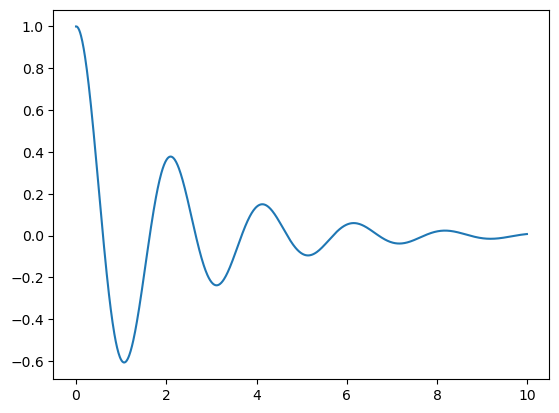

In [3]:
T = 1000
dt = 0.01
def simulate_basic(update_fn, x_init):
    xs = jnp.zeros((T, x_init.shape[0]))
    xs = xs.at[0, :].set(x_init)
    
    for t in range(1, T):
        x_current = xs[t - 1, :]
        x_next = update_fn(x_current, jnp.zeros(1), dt)
        xs = xs.at[t, :].set(x_next)
    
    return xs

%time xs = simulate_basic(state_update, jnp.array([1.0, 0.0]))
t = jnp.arange(0, T * dt, dt)
plt.plot(t, xs[:, 0])

The easiest thing we can do to speed up this code is to use JAX's just-in-time (JIT) compilation feature: this will take our `state_update` function and compile it to optimized XLA code, which can execute much faster. Usually there's some [tradeoff](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#to-jit-or-not-to-jit) here: the compilation takes some time, but if you call the function enough times (e.g. in the inner loop of a simulator), then it's worth it. There are some [constraints](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html#to-jit-or-not-to-jit) on what functions can and cannot be JIT'd, but our `state_update` function is a good candidate. Let's see what sort of speedups we can get.

CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.3 s


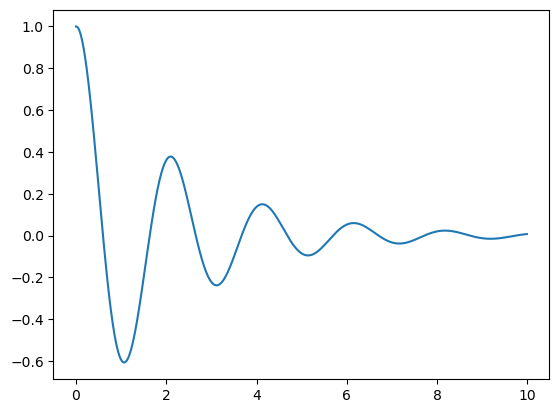

In [4]:
# Speedup 1: JIT the update function
%time xs = simulate_basic(jax.jit(state_update), jnp.array([1.0, 0.0]))
plt.plot(t, xs[:, 0])

So even when we account for compilation time, we're saving a solid second off of the time needed to simulate one rollout. If you re-run the cell above, JAX doesn't need to re-compile (that happens only when the function is called with inputs of a different shape), you'll see that the runtime drops again --- without compilation time, we're ~5x faster than we were previously!

The reason for this speedup is simple: both JAX and Numpy have put a fair amount of effort into making *individual operations* fast (e.g. every individual call to `sin` or `matmul`). Where JAX pulls ahead is that when we JIT a function, we allow JAX to optimize not only individual operations but *entire blocks of code*. This yields much of the speedup we saw above.

We can actually do one better. By default, JIT will trace your function's execution by feeding it a special type of array that acts as a generic input of a certain shape, then compile all the operations it saw during tracing into a single XLA code block. We don't have any loops in `state_update`, but if we did, JAX's default behavior would be to unroll the loop and try to compile multiple copies of the code in the loop body. This is pretty inefficient, which is why we didn't try to JIT `simulate_basic` (the compilation would have taken too long), but there *is* a way to optimize looping code in JAX: we simply have to use [XLA-specific looping constructs](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#structured-control-flow-primitives). Let's see that in action:

CPU times: user 69.5 ms, sys: 16 µs, total: 69.5 ms
Wall time: 67.9 ms


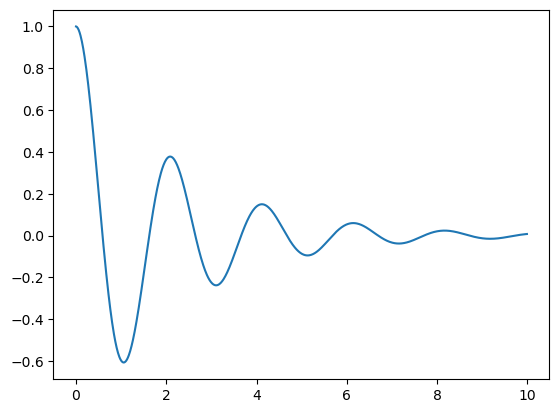

In [12]:
# Speedup 2: XLA looping construct
def simulate_scan_step(x_current, dummy_input):
    x_next = state_update(x_current, jnp.zeros(1), dt)
    return x_next, x_next

simulate_scan = lambda x_init: jax.lax.scan(simulate_scan_step, x_init, xs=None, length=T)[1]

%time xs = simulate_scan(jnp.array([1.0, 0.0]))

plt.plot(t, xs[:, 0])

By simply exposing a little more structure to JAX (by telling it the structure of our simulation loop), we're able to go from 2-5x faster (just JIT-ing `state_update`) to **50x** faster. We'll see in the next section that we can preserve these speedups even when we want to run multiple simulations at the same time.

## Stage 2: automatic vectorization

If you're used to writing standard Numpy or PyTorch code, your first thought may have been to write something like this for the dynamics function:
```
def dynamics_fn_batched(x, u):
    """Define damped pendulum dynamics"""
    g = 9.81
    d = 0.1
    l = 1.0
    m = 0.1
    
    theta = x[:, 0]
    theta_dot = x[:, 1]
    u = u[:, 0]
    
    dxdt = np.zeros_like(x)
    dxdt[:, 0] = theta_dot
    dxdt[:, 1] = (u - d * theta_dot - m * g * l * np.sin(theta)) / (m * l ** 2)
    
    return dxdt
```

The reason this code includes all of the extra `[:, ...]` indices is that we've manually specified that the leading axis of our arrays is a *batch dimension*. This isn't so hard for a function like this, but it can add a lot of cognitive overhead for writing and debugging code when we want to do fancier things like matrix multiplications with manual batching. This process of writing code to work with a batch dimension is often called *vectorization*, and JAX includes a function transformation to do this for us automatically.

*Side note:* the term "function transformation" gets thrown around a lot in JAX. It just means a function that takes another function as input and returns a different function as output, just like `jax.jit` took our function `state_update` and returned a faster, compiled version.

Let's see how we can use the auto-vectorization function transformation `jax.vmap` to simulate multiple trajectories at once (JAX also includes a transformation `jax.pmap` to parallelize a function across multiple devices, but we won't get into that here).

CPU times: user 61.3 ms, sys: 7.96 ms, total: 69.3 ms
Wall time: 68.1 ms


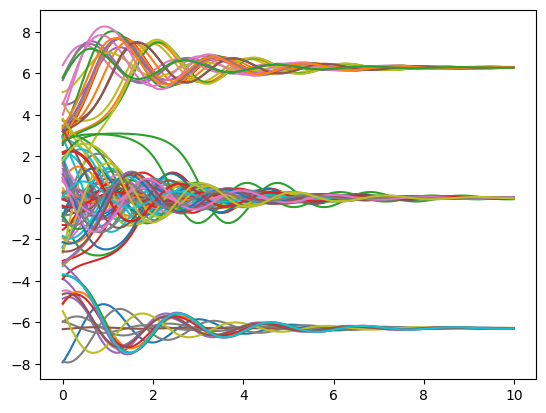

In [16]:
# Speedup 3: automatically vectorize
simulate_batched = jax.vmap(simulate_scan)

N = 100
prng_key = jax.random.PRNGKey(0)
x_inits = jnp.pi * jax.random.normal(prng_key, shape=(N, 2))

%time xs = simulate_batched(x_inits)

for i in range(N):
    plt.plot(t, xs[i, :, 0])

This is pretty awesome! If we just looped through all 100 cases we wanted to simulate, we would expect our code to take 100x as long to run, instead it just takes 15% longer to process 100x as much data! You can even re-run the cell above with `N = 10_000` to simulate 10,000 trajectories, which only takes ~2x as much time (although plotting that many trajectories might be difficult).

## Stage 3: automatic differentiation

Much of modern machine learning is based on simple gradient-based optimization, and a lot of the utility of libraries like PyTorch and Tensorflow is that they make it easy to do backpropagation (i.e. computing the gradient of some loss function with respect to neural network paramaters). JAX includes a general-purpose autodiff feature that makes it easy to make differentiable simulators and use them for optimization.

To see this in action, we'll walk through a simple policy optimization problem where we want to train a neural network to stabilize the pendulum around the upright position. Rather than doing this using some sort of RL algorithm, we'll just use the simulator we defined above and compute the gradients of our loss directly.

We can start by defining a simple neural network for our policy. We can see that the randomly initialized network doesn't perform very well.

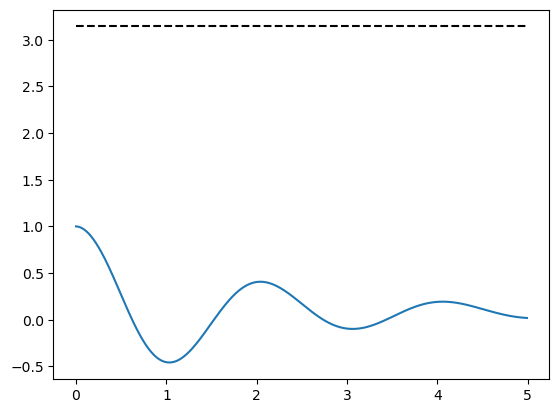

In [17]:
# Swingup task: can we train a neural network policy to swingup the pendulum?
class Policy(eqx.Module):  # using Equinox, a JAX neural network library
    layers: list

    def __init__(self, key):
        key1, key2, key3, key4 = jax.random.split(key, 4)
        self.layers = [eqx.nn.Linear(2, 32, key=key1),
                       eqx.nn.Linear(32, 32, key=key2),
                       eqx.nn.Linear(32, 32, key=key3),
                       eqx.nn.Linear(32, 1, key=key4)]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return self.layers[-1](x)
    

T = 500
def loss_fn(policy, x_init):
    # Simulate for a bunch of steps steps and penalize distance from vertical
    def step_policy(x_current, dummy_input):
        x_next = state_update(x_current, policy(x_current), dt)
        return x_next, x_next

    simulate_scan = lambda x_init: jax.lax.scan(step_policy, x_init, xs=None, length=T)[1]
    simulate_scan = jax.vmap(simulate_scan)
    trajectory = simulate_scan(x_init)
    
    target = jnp.zeros_like(trajectory) + jnp.array([jnp.pi, 0.0])
    loss = ((trajectory - target) ** 2).mean()
    
    return loss

loss_and_grad = jax.jit(jax.value_and_grad(loss_fn))

# Create a random policy
prng_key = jax.random.PRNGKey(0)
prng_key, subkey = jax.random.split(prng_key)
policy = Policy(subkey)

# How well does this policy work?
def step_policy(x_current, dummy_input):
    x_next = state_update(x_current, policy(x_current), dt)
    return x_next, x_next

simulate_scan = lambda x_init: jax.lax.scan(step_policy, x_init, xs=None, length=T)[1]
xs = simulate_scan(jnp.array([1.0, 0.0]))
t = jnp.arange(0, T * dt, dt)
plt.plot(t, xs[:, 0])
plt.plot(t, t * 0 + jnp.pi, "k--")

Let's see what happens if we train for a couple of iterations

Iter 0, loss 2.0722157955169678
Iter 20, loss 2.0704777240753174
Iter 40, loss 2.0688469409942627
Iter 60, loss 2.067312240600586
Iter 80, loss 2.0658679008483887
Iter 99, loss 2.064570426940918
Trained on 5,000,000 environmental interactions in 3.91 seconds; final loss = 2.065


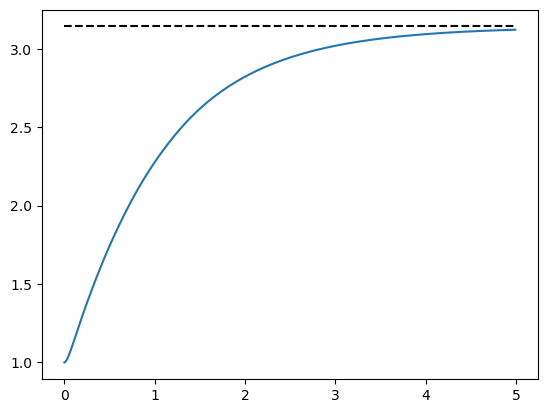

In [24]:
# Generate training data
N = 100
prng_key = jax.random.PRNGKey(0)
x_inits = jnp.pi * jax.random.normal(prng_key, shape=(N, 2))

# Train
iters = 100
learning_rate = 1e-2
t_start = time.time()
for i in range(iters):
    loss, grads = loss_and_grad(policy, x_inits)
    policy = jax.tree_util.tree_map(lambda m, g: m - learning_rate * g, policy, grads)
    
    if i % 20 == 0 or i == iters - 1:
        print(f"Iter {i}, loss {loss}")

t_end = time.time()
print("Trained on {:,d} environmental interactions in {:.2f} seconds; final loss = {:.3f}".format(T * N * iters, t_end - t_start, loss))

def step_policy(x_current, dummy_input):
    x_next = state_update(x_current, policy(x_current), dt)
    return x_next, x_next

simulate_scan = lambda x_init: jax.lax.scan(step_policy, x_init, xs=None, length=T)[1]
xs = simulate_scan(jnp.array([1.0, 0.0]))
t = jnp.arange(0, T * dt, dt)
plt.plot(t, xs[:, 0])
plt.plot(t, t * 0 + jnp.pi, "k--")

We can also see how well it works on a variety of initial conditions

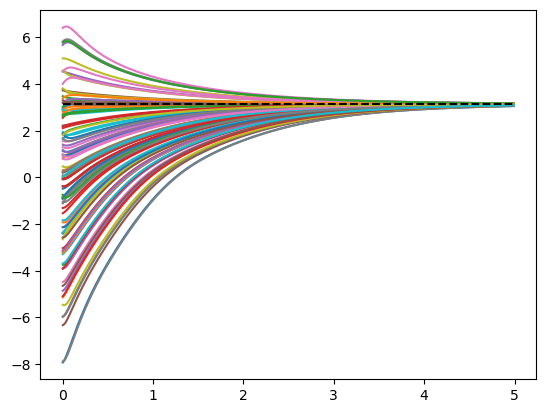

In [27]:
xs = jax.vmap(simulate_scan)(x_inits)
for i in range(N):
    plt.plot(t, xs[i, :, 0])
plt.plot(t, t * 0 + jnp.pi, "k--")

Not bad!

## Conclusion

We've seen how to write some simple functions in the JAX style, and we've seen how we can get pretty impressive speedups (several orders of magnitude) just from using simple JAX transformations like `jit` and `vmap`. We've also seen how JAX's automatic differentiation enables you to implement cool optimization algorithms relatively easily.

Anecdotally, I've been using JAX in my research for almost a year now, mainly to build differentiable simulators and temporal logics for a couple of [recent](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=FkDdz9gAAAAJ&sortby=pubdate&citation_for_view=FkDdz9gAAAAJ:W7OEmFMy1HYC) [papers](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=FkDdz9gAAAAJ&sortby=pubdate&citation_for_view=FkDdz9gAAAAJ:Y0pCki6q_DkC). Please feel free to reach out to me (cbd [at] mit [dot] edu or on Slack) if you have any qustions about using JAX in your research. For REALM members, Oswin and Kwesi also have some experience with JAX and can probably help as well.